In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('names.txt','r').read().splitlines()
words[:5]


['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [3]:
# building the vocabulary with mapping from characters to integers and vice-versa
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [4]:
# building the dataset
block_size = 8 # context length: how many characters do we take to predict the next one

def build_dataset(words):
    X, Y = [], []

    for w in words:
        
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # cropping and appending

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])


torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [5]:
for x, y in zip(Xtr[:20], Ytr[:20]):
    print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

........ --> y
.......y --> u
......yu --> h
.....yuh --> e
....yuhe --> n
...yuhen --> g
..yuheng --> .
........ --> d
.......d --> i
......di --> o
.....dio --> n
....dion --> d
...diond --> r
..diondr --> e
.diondre --> .
........ --> x
.......x --> a
......xa --> v
.....xav --> i
....xavi --> e


In [25]:
# defining classes for linear and batchnorm
# We will create classes close to what is there in pytorch

class Linear:
    
    def __init__(self, fan_in, fan_out, bias = True):
        self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    
class BatchNorm1d:

    def __init__(self, dim, eps = 1e-5, momentum = 0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running momentum update
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        if self.training:
            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:
                dim = (0,1 )
            xmean = x.mean(dim, keepdim = True) # batch mean
            xvar = x.var(dim, keepdim = True) # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)       # normalize to unit variance
        self.out = self.gamma * xhat + self.beta

        # update the buffers:
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_Var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
    
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []
    
class Embedding:
    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim))

    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out
    
    def parameters(self):
        return [self.weight]
    
class Flatten:
    def __call__(self, x):
        self.out = x.view(x.shape[0], -1)
        return self.out
    
    def parameters(self):
        return []
    
class FlattenConsecutive:
    def __init__(self, n):
        self.n = n
    
    def __call__(self, x):
        B, T, C = x.shape
        x = x.view(B, T//self.n, C*self.n)
        if x.shape[1] == 1:
            x = x.squeeze(dim = 1)
        self.out = x
        return self.out

    def parameters(self):
        return []
    
# sequential class: similar to pytorch
class Sequential:

    def __init__(self, layers):
        self.layers = layers

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out
    
    def parameters(self):
        # get paramters of all layers and stretch them out into one list
        return [p for layer in self.layers for p in layer.parameters()]


In [27]:
torch.manual_seed(42);

In [31]:

n_embd = 10 # dimensionality if character embedding vectors
n_hidden = 68  # number of neurons in hidden layer

# C = torch.randn((vocab_size, n_embd))

model = Sequential([
    Embedding(vocab_size, n_embd),
    FlattenConsecutive(2),Linear(n_embd * 2, n_hidden, bias = False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2),Linear(n_hidden * 2, n_hidden, bias = False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2),Linear(n_hidden * 2, n_hidden, bias = False), BatchNorm1d(n_hidden), Tanh(),    
    Linear(n_hidden, vocab_size)
])


with torch.no_grad():
    # last layer; make less confident
    model.layers[-1].weight *= 0.1

        
parameters = model.parameters()
print(sum(p.nelement() for p in parameters))    # number of parameters in total
for p in parameters:
    p.requires_grad = True




22397


In [32]:
ix = torch.randint(0, Xtr.shape[0], (4, ))
Xb, Yb = Xtr[ix], Ytr[ix]
logits = model(Xb)
print(Xb.shape)
Xb

torch.Size([4, 8])


tensor([[ 0,  0,  0,  0,  0,  0, 11,  5],
        [ 0,  0,  0,  0,  0,  0,  6, 18],
        [ 0,  0,  0,  0,  0,  0,  0,  1],
        [ 0,  0,  0,  0,  0,  0,  1,  4]])

In [33]:
for layer in model.layers:
    print(layer.__class__.__name__, ':', tuple(layer.out.shape))

Embedding : (4, 8, 10)
FlattenConsecutive : (4, 4, 20)
Linear : (4, 4, 68)
BatchNorm1d : (4, 4, 68)
Tanh : (4, 4, 68)
FlattenConsecutive : (4, 2, 136)
Linear : (4, 2, 68)
BatchNorm1d : (4, 2, 68)
Tanh : (4, 2, 68)
FlattenConsecutive : (4, 136)
Linear : (4, 68)
BatchNorm1d : (4, 68)
Tanh : (4, 68)
Linear : (4, 27)


In [34]:
# model training

max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    # constructing the minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i %10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())  # log loss looks nicer, usual loss looks like a hockey stick
    
        

      0/ 200000: 3.3050
  10000/ 200000: 2.2553
  20000/ 200000: 2.0259
  30000/ 200000: 1.9693
  40000/ 200000: 1.7459
  50000/ 200000: 1.8932
  60000/ 200000: 1.8176
  70000/ 200000: 2.4160
  80000/ 200000: 1.6938
  90000/ 200000: 1.7683
 100000/ 200000: 1.9979
 110000/ 200000: 2.2581
 120000/ 200000: 1.9859
 130000/ 200000: 2.2595
 140000/ 200000: 2.0132
 150000/ 200000: 2.1225
 160000/ 200000: 1.9952
 170000/ 200000: 1.8707
 180000/ 200000: 2.0105
 190000/ 200000: 2.1492


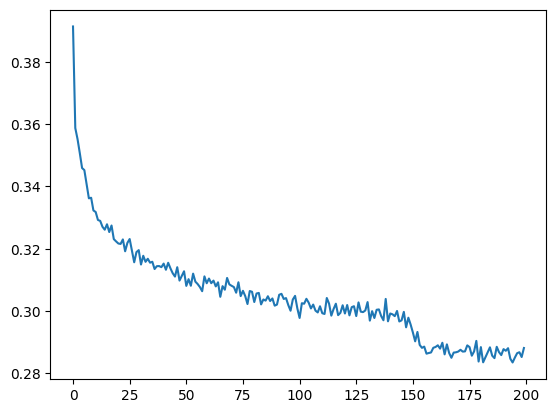

In [35]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [36]:
# put layers into eval mode
for layer in model.layers:
    layer.training = False

In [37]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.392498016357422
val 2.5174341201782227


In [38]:
# sample from the model 

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim = 1)
        
        ix = torch.multinomial(probs, num_samples = 1).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix==0:
            break
    print(''.join(itos[i] for i in out))

lotcieth.
nicarianco.
briydandy.
ariannah.
kstouln.
scexlio.
ivaan.
malori.
scyliny.
chetty.
contrane.
zvonexanti.
molsin.
maseya.
christie.
nachent.
moharaydon.
mokkynnee.
xsounethansh.
sileeanna.


In [ ]:
# PROBLEMS AND FIXES
# 1. the plot was ugly, now using an average over steps
# 2. too many steps in the layers it looks bad. We create layers for embedding and view

# increasing from 3 to 8 (context length) improves the model performance. We could keep improving but let's look at the overarching issue
# The problem with the current approach (MLP) was that we were crushing all the information into a single input. Hence we try a new approach (WaveNet)


tensor([[7.9362e-01, 1.1545e-03, 6.4093e-04, 9.0203e-05, 8.3690e-05, 4.8095e-04,
         1.0783e-04, 1.9810e-05, 1.8296e-01, 1.1184e-04, 4.7305e-05, 1.0683e-04,
         3.1625e-03, 8.8049e-03, 2.1802e-04, 6.8577e-05, 2.3143e-06, 2.2258e-05,
         5.9482e-04, 1.8143e-03, 8.3900e-05, 2.6960e-03, 1.7266e-03, 1.1045e-03,
         3.8003e-05, 6.4799e-05, 1.6869e-04]], grad_fn=<SoftmaxBackward0>)